In [1]:
!pip install torch torchvision scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Loading the California Housing Data here
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target
print("Initial data shape:", X_housing.shape, y_housing.shape)

threshold = y_housing.mean()
y_housing_binary = (y_housing > threshold).astype(int)
print("Threshold for classification:", threshold)
print("Binary target values (first 10):", y_housing_binary[:10])

X_train_h, X_test_h, y_train_h, y_test_h, y_train_h_binary, y_test_h_binary = train_test_split(
    X_housing, y_housing, y_housing_binary, test_size=0.2, random_state=42
)
print("Train/Test split shapes:", X_train_h.shape, X_test_h.shape)

scaler_h = StandardScaler()
X_train_h = scaler_h.fit_transform(X_train_h)
X_test_h = scaler_h.transform(X_test_h)

X_train_h_tensor = torch.tensor(X_train_h, dtype=torch.float32).to(device)
X_test_h_tensor = torch.tensor(X_test_h, dtype=torch.float32).to(device)
y_train_h_tensor = torch.tensor(y_train_h, dtype=torch.float32).view(-1, 1).to(device)
y_test_h_tensor = torch.tensor(y_test_h, dtype=torch.float32).view(-1, 1).to(device)
y_train_h_binary_tensor = torch.tensor(y_train_h_binary, dtype=torch.float32).view(-1, 1).to(device)
y_test_h_binary_tensor = torch.tensor(y_test_h_binary, dtype=torch.float32).view(-1, 1).to(device)


Initial data shape: (20640, 8) (20640,)
Threshold for classification: 2.068558169089147
Binary target values (first 10): [1 1 1 1 1 1 1 1 1 1]
Train/Test split shapes: (16512, 8) (4128, 8)


In [5]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FeedforwardNN, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, classification=False):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        if classification:
            x = self.sigmoid(x)
        return x

model_regression_h = FeedforwardNN(X_train_h.shape[1], 1).to(device)
model_classification_h = FeedforwardNN(X_train_h.shape[1], 1).to(device)
print("Models initialized.")


Models initialized.


In [6]:
criterion_regression = nn.MSELoss()
criterion_classification = nn.BCELoss()
optimizer_regression = optim.Adam(model_regression_h.parameters(), lr=0.01)
optimizer_classification = optim.Adam(model_classification_h.parameters(), lr=0.01)
print("Loss functions and optimizers defined.")

Loss functions and optimizers defined.


In [7]:
def train_model(model, optimizer, X_train, y_train, criterion, epochs=100, classification=False):
    for epoch in range(epochs):
        model.train()
        predictions = model(X_train, classification=classification)
        loss = criterion(predictions, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

print("Training Regression Model")
train_model(model_regression_h, optimizer_regression, X_train_h_tensor, y_train_h_tensor, criterion_regression)

print("Training Classification Model")
train_model(model_classification_h, optimizer_classification, X_train_h_tensor, y_train_h_binary_tensor, criterion_classification, classification=True)


Training Regression Model
Epoch 10/100, Loss: 0.9632
Epoch 20/100, Loss: 0.7115
Epoch 30/100, Loss: 0.5830
Epoch 40/100, Loss: 0.4771
Epoch 50/100, Loss: 0.4374
Epoch 60/100, Loss: 0.4145
Epoch 70/100, Loss: 0.3985
Epoch 80/100, Loss: 0.3852
Epoch 90/100, Loss: 0.3750
Epoch 100/100, Loss: 0.3677
Training Classification Model
Epoch 10/100, Loss: 0.4451
Epoch 20/100, Loss: 0.3734
Epoch 30/100, Loss: 0.3601
Epoch 40/100, Loss: 0.3422
Epoch 50/100, Loss: 0.3356
Epoch 60/100, Loss: 0.3205
Epoch 70/100, Loss: 0.3144
Epoch 80/100, Loss: 0.3078
Epoch 90/100, Loss: 0.3012
Epoch 100/100, Loss: 0.2948


In [9]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model_regression(model, X_test, y_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations
        predictions = model(X_test).cpu().numpy()  # Get predictions
        mse = mean_squared_error(y_test.cpu().numpy(), predictions)  # Compute MSE
        r2 = r2_score(y_test.cpu().numpy(), predictions)  # Compute R² score
        print("Regression predictions (first 5):", predictions[:5].flatten())  # Display sample predictions
    return mse, r2


In [11]:



mse_h, r2_h = evaluate_model_regression(model_regression_h, X_test_h_tensor, y_test_h_tensor)
print(f"California Housing Regression - MSE: {mse_h:.4f}, R-squared: {r2_h:.4f}")


Regression predictions (first 5): [0.5283102 1.7115058 3.7447088 2.7989867 2.8905058]
California Housing Regression - MSE: 0.3821, R-squared: 0.7084


In [16]:
# Function to Evaluate the Classification Model
def evaluate_model_classification(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test, classification=True).cpu().numpy() > 0.5  # Convert probabilities to binary (0 or 1)
        accuracy = accuracy_score(y_test.cpu().numpy(), predictions)
        cm = confusion_matrix(y_test.cpu().numpy(), predictions)
        print("Classification predictions (first 5):", predictions[:5].flatten())
    return accuracy, cm


# Evaluate the Classification model for California Housing Dataset
accuracy_h, cm_h = evaluate_model_classification(model_classification_h, X_test_h_tensor, y_test_h_binary_tensor)
print(f"California Housing Classification Model - Accuracy: {accuracy_h:.4f}")



Classification predictions (first 5): [False False  True  True  True]
California Housing Classification Model - Accuracy: 0.8719


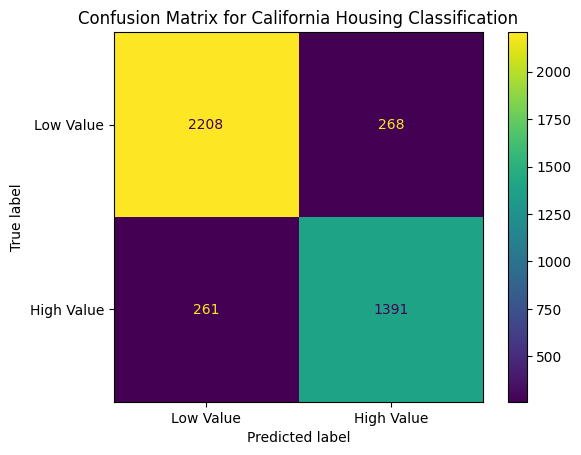

In [17]:


ConfusionMatrixDisplay(confusion_matrix=cm_h, display_labels=["Low Value", "High Value"]).plot()
plt.title("Confusion Matrix for California Housing Classification")
plt.show()
